In [9]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [10]:
df = pd.read_csv('/Users/sky/PycharmProjects/BDRAR_SKY/BDRAR/ckpt/sbu_hungerstation_glovo/2022_11_11_19_07_01/binary_threshold_ber.csv')
# df = df.sort_values(by = '')
df.head()

,Unnamed: 0,img_name,ratio_threshold,score_threshold,ber
0,0,33b151882a4005bf36d0a5461c4c15f2,0.355505,0.5,3.303
1,1,b108694403905ce1fb6b9f806857f7c3,0.079966,0.5,31.271
2,2,6457ae992c28813ee33f6a3652f966d7,0.342814,0.5,27.350
3,3,b69d39cb8c9573cb41e260b5a40666c6,0.578405,0.5,1.713
4,4,4180f6fc4e66c640abec03fe82f01296,0.331437,0.5,3.942


In [11]:
# df_ground_truth = pd.read_csv(os.path.join('/Users/sky/PycharmProjects/BDRAR_SKY/BDRAR/ckpt/BDRAR/calculate_precision_recall/BDRAR_hungerstation_prediction_3001_performance', 'analysis.csv'), index_col=0)
# df_ground_truth = df_ground_truth[['img_name', 'good_shadow' ]]
# df_ground_truth
# df.merge(df_ground_truth, on='img_name')

# Processes
- 1. Calculate a "bi_threshold" for each image, which is defined as "np.sum(img_npy >= 0.5) / np.sum(img_npy >= 0.01)". To be more precise: the model gives a score that is between 0 and 1 for each pixel, and finally output a list of score. We define the threshold as the ratio between the number of scores bigger than 0.5 and all non-zero scores. For instance, if we set the threshold = 0.5 to be a good shadow for this specific image, it is equivalent to say that the image has a good shadow only if the number of scores that bigger than 0.5 is more than 50% amonge all non-zero scores.
- 2. The step 1 will produce a csv whose columns are img_name, ratio, ber. The ber with a ber_threshold will define which shadow is ground truth (positive or negative). The threshold on the ratio will define which image is predicted as positive or negative.
- 3. With true positive, true negative, and false positive calculated from step 2, we can calculate the precision and recall with respect to the ratio thresholds.

In [16]:
thresholds = [i for i in np.linspace(0, 1.0, 10)]
ber_thresholds = [i for i in range(5, 60, 10)]
# print(thresholds)
print(ber_thresholds)
ber_threshold = 30
threshold_list = []
precision_list = []
recall_list = []
ber_threshold_list = []
score_threshold_list = []
for k in df['score_threshold'].unique():
    df_tmp = df[df['score_threshold'] == k]
    print(len(df_tmp))
    # df_tmp = pd.merge(df_tmp, df_ground_truth, on = 'img_name')
    for j in ber_thresholds:
        for i in thresholds:
            ber_threshold_list.append(j)
            threshold_list.append(i)
            score_threshold_list.append(k)
            tp = len(df_tmp[(df_tmp['ratio_threshold']<= i) & (df_tmp['ber'] <= j)])
            fp = len(df_tmp[(df_tmp['ratio_threshold']<= i) & (df_tmp['ber'] > j)])
            fn = len(df_tmp[(df_tmp['ratio_threshold'] > i) & (df_tmp['ber'] <= j)])
            # tp = len(df_tmp[(df_tmp['ratio_threshold']>= i) & (df_tmp['good_shadow'] == 1)])
            # fp = len(df_tmp[(df_tmp['ratio_threshold']>= i) & (df_tmp['good_shadow'] == 0)])
            # fn = len(df_tmp[(df_tmp['ratio_threshold'] < i) & (df_tmp['good_shadow'] == 1)])
            if tp + fp == 0:
                precision = 1
                recall = 0
            else:
                precision = tp / (tp + fp)
                recall = tp / (tp + fn)
            precision_list.append(precision)
            recall_list.append(recall)

df_new = pd.DataFrame(data=zip(score_threshold_list, ber_threshold_list, threshold_list, precision_list, recall_list),
                  columns=['score_threshold', 'ber_threshold', 'threshold', 'precision', 'recall'])
df_new.describe()


[5, 15, 25, 35, 45, 55]
129
129
129
129
129


,score_threshold,ber_threshold,threshold,precision,recall
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.750000,30.000000,0.500000,0.838936,0.771083
std,0.177072,17.106786,0.319676,0.223337,0.349964
min,0.500000,5.000000,0.000000,0.000000,0.000000
25%,0.625000,15.000000,0.222222,0.785286,0.627451
50%,0.750000,30.000000,0.500000,0.937984,0.983799
75%,0.875000,45.000000,0.777778,0.992248,1.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000


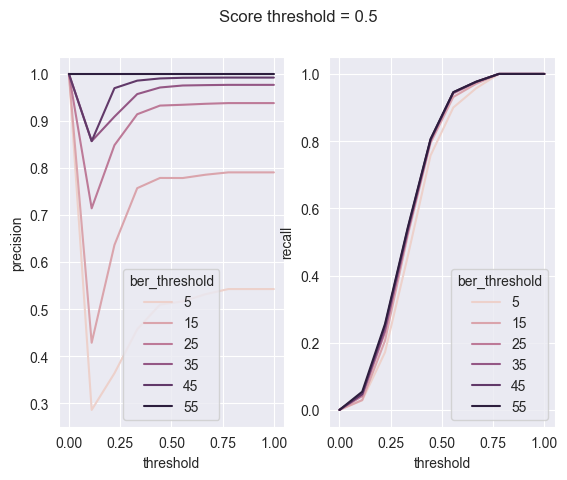

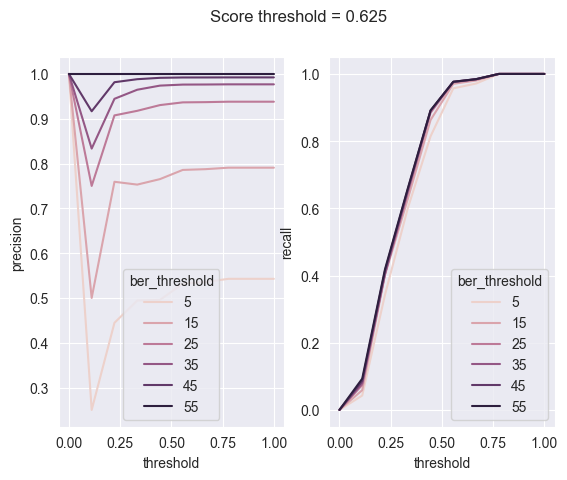

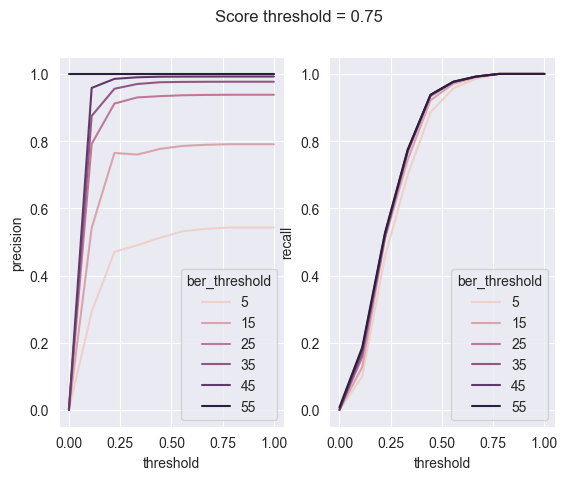

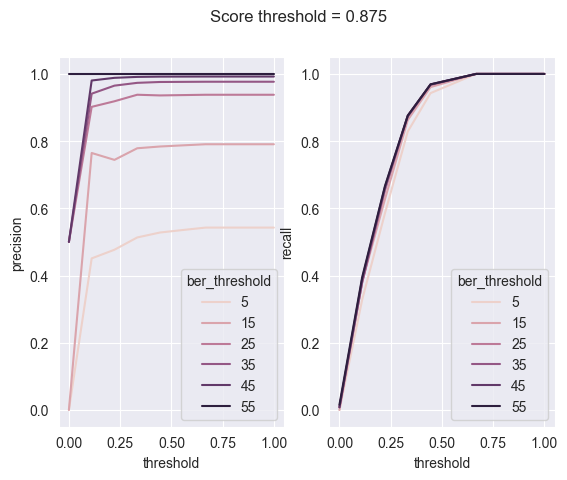

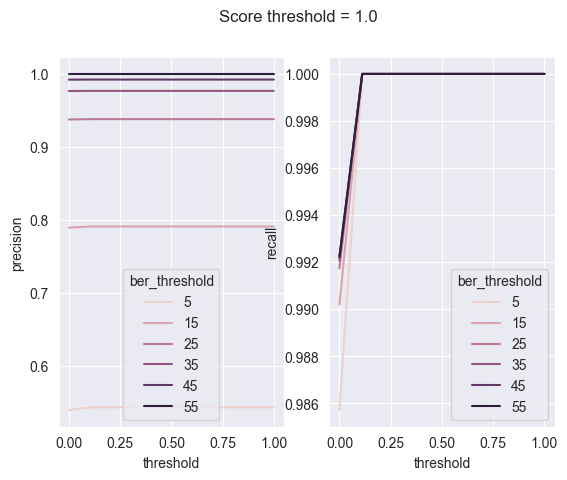

In [17]:
for i in df['score_threshold'].unique():
    fig, axes = plt.subplots(1, 2)
    fig.suptitle('Score threshold = ' + str(i))
    sns.lineplot(ax=axes[0],data=df_new[df_new['score_threshold']==i], x='threshold',y = 'precision', hue = 'ber_threshold')
    sns.lineplot(ax=axes[1],data=df_new[df_new['score_threshold']==i], x='threshold',y = 'recall', hue = 'ber_threshold')


First the ber_threshold seems does not affect the overall behavior of precision and recall with respect to the threshold. Thus we do not need to care too much about ber_threshold when choosing the ratio threshold. 

From the above figure we can see that the threshold can be set at about 0.7 so that we have high precision and recall. 

The next step is to check the situation when we change the pixel score threshold (that is currently 0.5).

In [18]:
# sns.lineplot(data=df_new, x='recall',y = 'precision', color='r', label = 'recall vs precision')

# ax2 = plt.twinx()
# sns.lineplot(data=df_new, x='recall',y = 'threshold', color='b', ax=ax2)

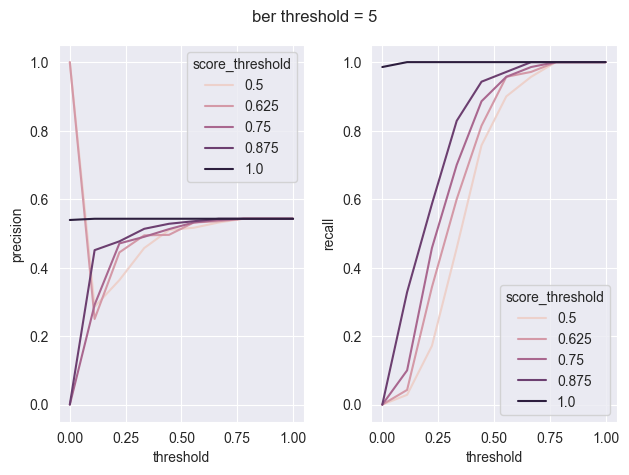

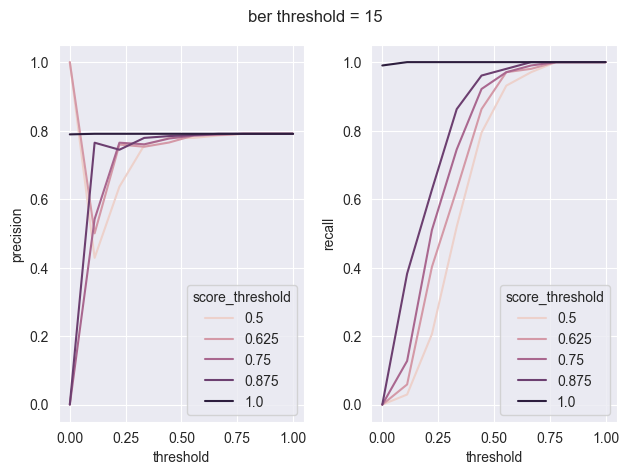

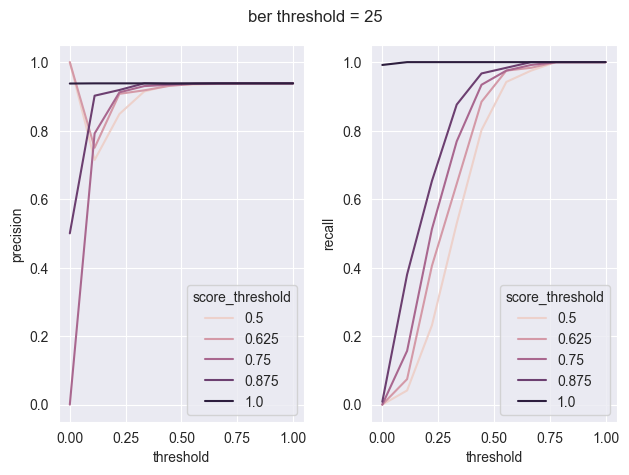

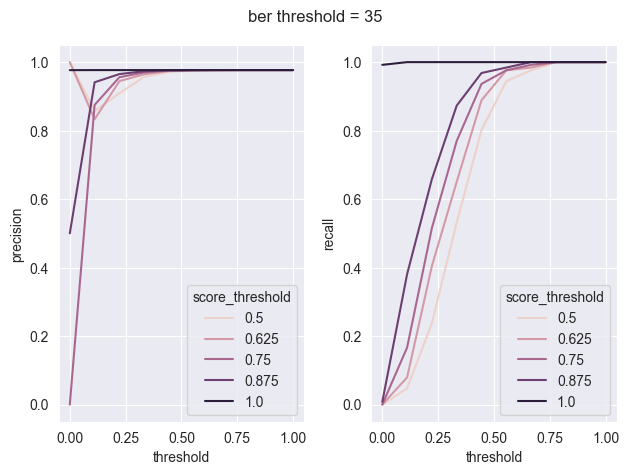

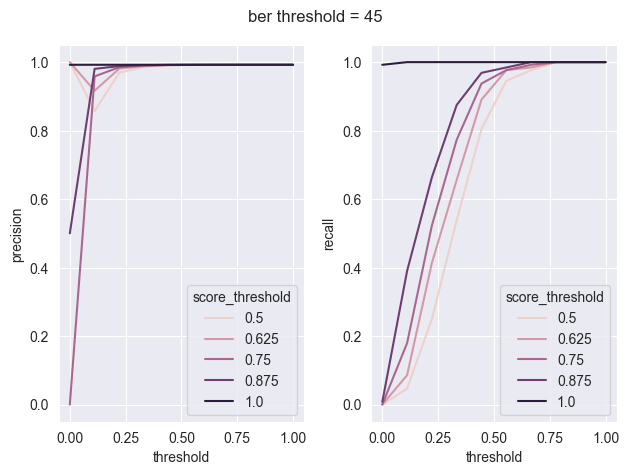

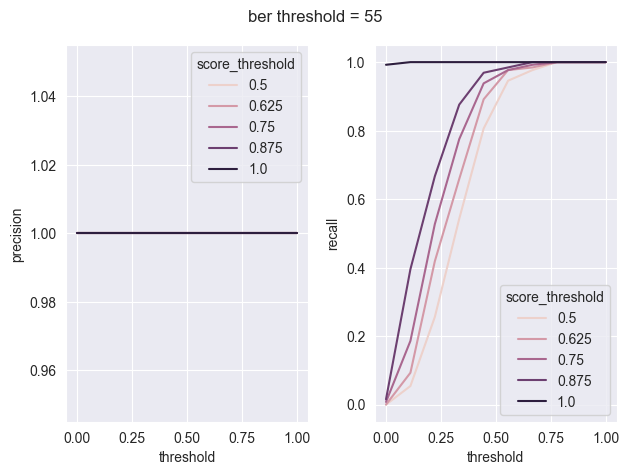

In [19]:
for i in ber_thresholds:    
    fig, axes = plt.subplots(1, 2)
    fig.suptitle('ber threshold = ' + str(i))
    sns.lineplot(ax=axes[0],data=df_new[df_new['ber_threshold']==i], x='threshold',y = 'precision', hue = 'score_threshold')
    sns.lineplot(ax=axes[1],data=df_new[df_new['ber_threshold']==i], x='threshold',y = 'recall', hue = 'score_threshold')
    plt.tight_layout()


# Finally conclusion
ber threshold = 15, ratio threshold = 0.7 and score threshold = 0.7

0

0.8928571428571429

,Unnamed: 0,ratio_threshold,score_threshold,ber,good_shadow
count,129.000000,129.000000,1.290000e+02,129.000000,129.000000
mean,451.000000,0.208597,7.000000e-01,9.576295,0.550388
std,37.383151,0.129166,1.114551e-16,10.370244,0.499394
min,387.000000,0.005134,7.000000e-01,0.606000,0.000000
25%,419.000000,0.125294,7.000000e-01,2.203000,0.000000
50%,451.000000,0.188999,7.000000e-01,5.178000,1.000000
75%,483.000000,0.271952,7.000000e-01,14.360000,1.000000
max,515.000000,0.667591,7.000000e-01,42.556000,1.000000
